In [1]:
import sys
assert sys.version_info >= (3,7)

In [2]:
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import tarfile
from pathlib import Path 
import urllib.request
import pandas as pd

def load_housing_data():
    tarfile_path = Path('datasets/housing.tgz')
    if not tarfile_path.is_file():
        Path('datasets').mkdir(parents=True,exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url,tarfile_path)
        with tarfile.open(tarfile_path) as housing_tarball:
            housing_tarball.extractall(path='datasets')
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing_df = load_housing_data()


In [4]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing_df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

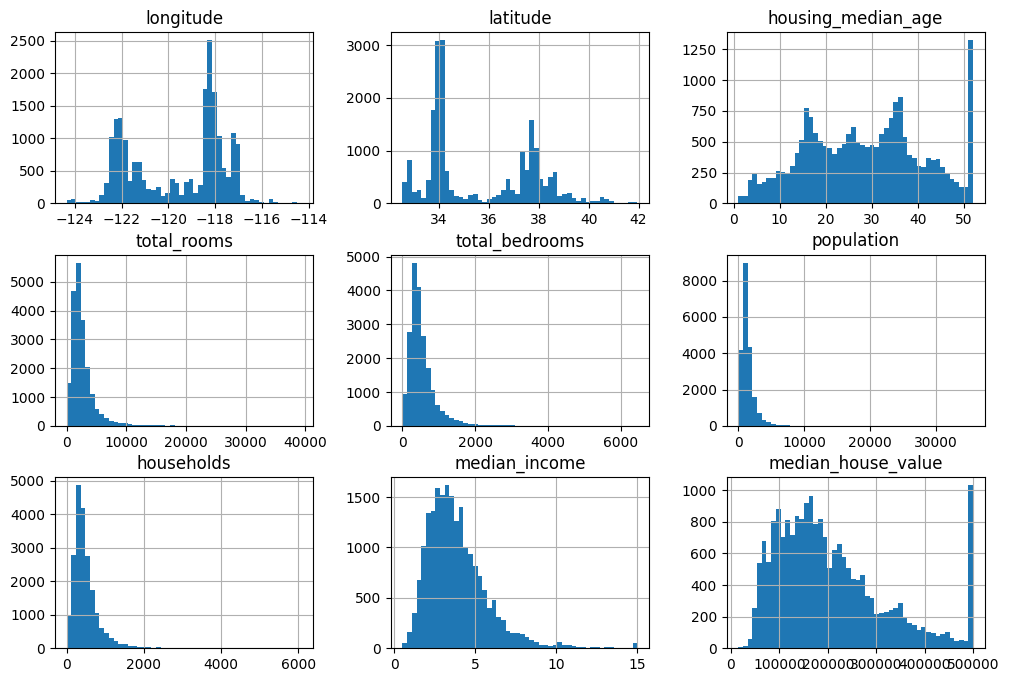

In [6]:
import matplotlib.pyplot as plt

housing_df.hist(bins=50, figsize=(12,8))
plt.show()

In [7]:
housing_df['median_income'].head()

0    8.3252
1    8.3014
2    7.2574
3    5.6431
4    3.8462
Name: median_income, dtype: float64

In [8]:
import numpy as np

def split_train_test_sets(data,ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(ratio * len(data))
    train_indices = shuffled_indices[test_size:]
    test_indices = shuffled_indices[:test_size]
    return data.iloc[train_indices], data.iloc[test_indices]

train_data, test_data = split_train_test_sets(housing_df, 0.2)
print(len(train_data))
print(len(test_data))

16512
4128


In [9]:
### Another way could be dividing using hash function which always yields same hash function

from zlib import crc32
def is_id_in_test_set(id, test_ratio):
    return crc32(np.int64(id)) < test_ratio * 2**32

def split_data(data, id_column, ratio):
    ids = data[id_column]
    int_test_data = ids.apply(lambda id_: is_id_in_test_set(id_,ratio))
    return data.loc[~int_test_data], data.loc[int_test_data]

housing_df["id"] = housing_df["longitude"] * 1000 + housing_df["latitude"]
train_data, test_data = split_data(housing_df,'id', 0.2)
print(len(train_data))
print(len(test_data))


16322
4318


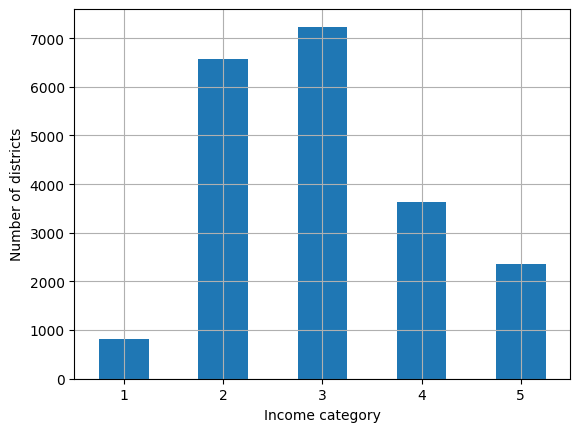

In [10]:
## Median is important attribute but it continuous. Let's compare difference between stratified sample and random sampling

housing_df['income_cat'] = pd.cut(housing_df['median_income'],bins=[0,1.5,3.0,4.5,6,np.inf], labels=[1,2,3,4,5])
housing_df['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category");
plt.ylabel("Number of districts")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

strat_train_data, strat_test_data = train_test_split(housing_df, test_size=0.2, stratify=housing_df['income_cat'], random_state=42)

strat_test_data['income_cat'].value_counts()/len(strat_test_data)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [12]:
housing_df['income_cat'].value_counts()/len(housing_df)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [13]:
strat_test_data['income_cat'].value_counts()

income_cat
3    1447
2    1316
4     728
5     472
1     165
Name: count, dtype: int64

In [14]:
for set in (strat_test_data, strat_train_data):
    set.drop('income_cat', axis=1, inplace=True)

In [15]:
housing = housing_df.copy()

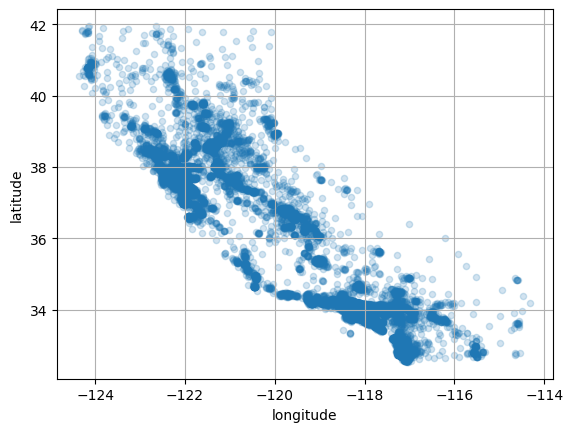

In [19]:
housing.plot(kind='scatter', x='longitude',y='latitude', grid=True, alpha=0.2)
plt.show()